In [1]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import re
from networkx.algorithms import community

In [2]:
edges=pd.read_csv("mlb_games.csv",encoding="utf-16")
nodes=pd.read_csv("mlb_teams.csv",encoding="utf-16")

edges=edges.dropna(subset=['home_team','away_team'])

team_mapping=dict(zip(nodes['prefix_1'],nodes['team']))

def clean_score(score):
  score_str=str(score)
  match=re.search(r'(\d+)-(\d+)',score_str)
  if match:
    return int(match.group())
  return 0




In [3]:
if 'home_score_clean' not in edges.columns:
    edges['home_score_clean'] = edges['home_team_score']
if 'away_score_clean' not in edges.columns:
    edges['away_score_clean'] = edges['away_team_score']

G=nx.Graph()
G_directed=nx.DiGraph()

for index,row in edges.iterrows():
    home_team=row['home_team']
    away_team=row['away_team']
    u=team_mapping.get(home_team,home_team)
    v=team_mapping.get(away_team,away_team)
    if not G.has_edge(u,v):
        G.add_edge(u,v)
    h_score=row['home_score_clean']
    a_score=row['away_score_clean']
    winner,loser=None,None
    if h_score>a_score:
        winner=u
        loser=v
    elif h_score<a_score:
        winner=v
        loser=u
    if winner and loser:
        if not G_directed.has_edge(winner,loser):
            G_directed.add_edge(winner,loser)

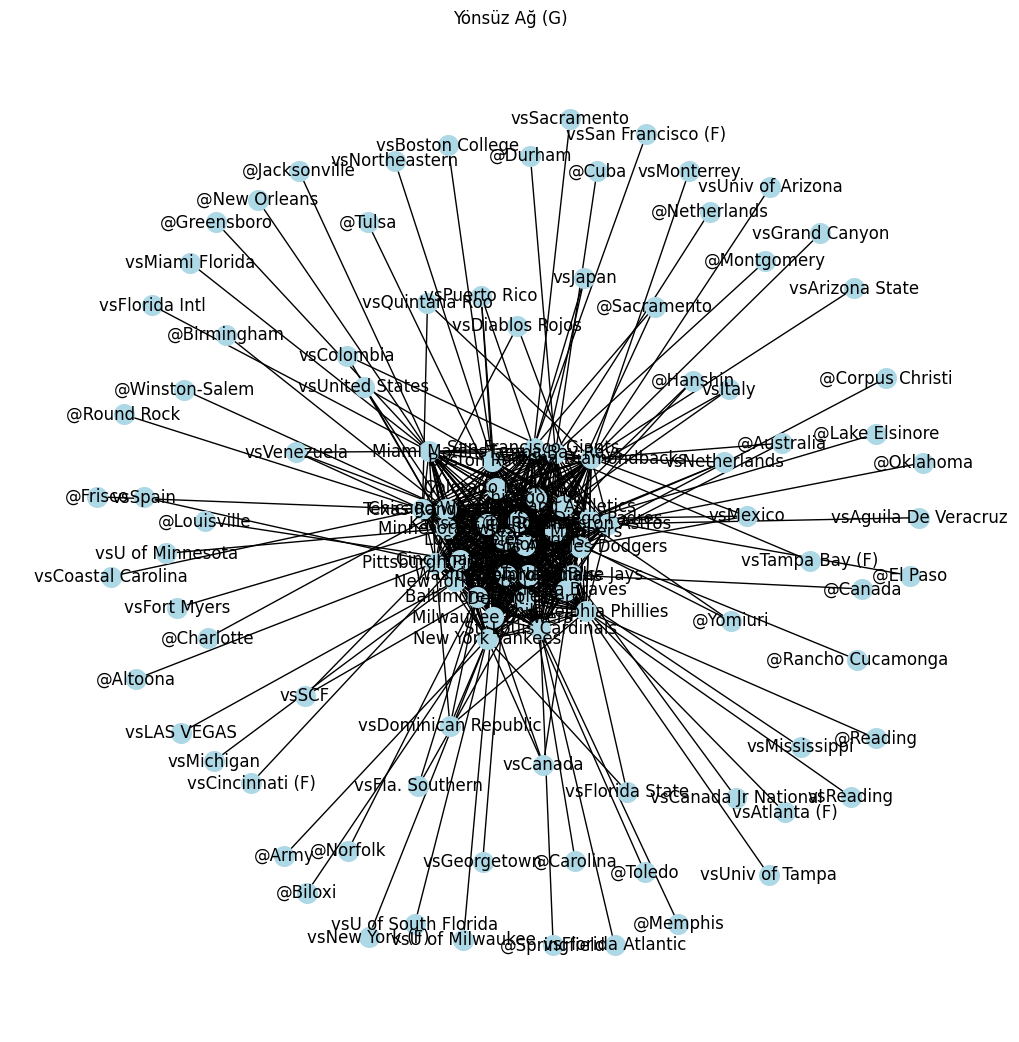

In [4]:
plt.figure(figsize=(10,10))
nx.draw(G,with_labels="True",node_size=200,node_color="lightblue")
plt.title("Yönsüz Ağ (G)")
plt.show()

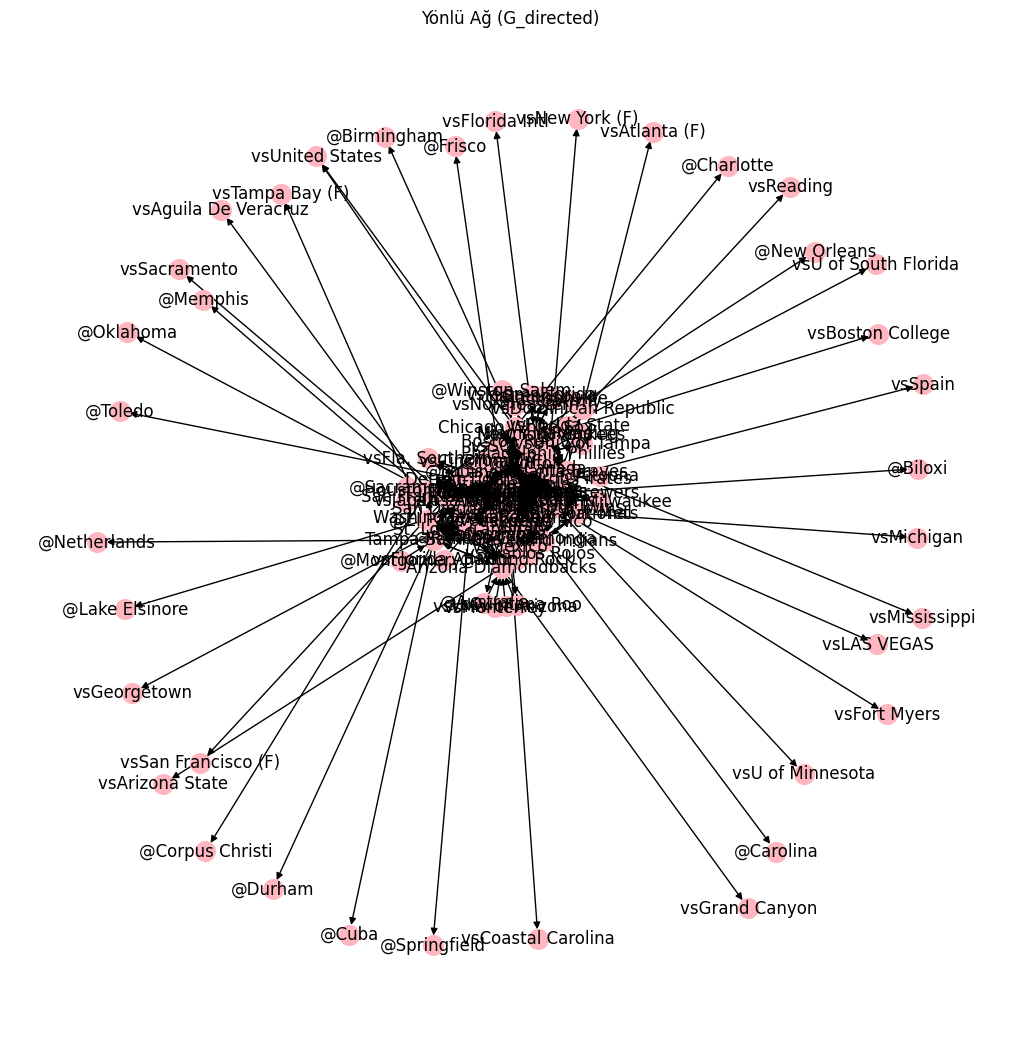

In [5]:
plt.figure(figsize=(10,10))
nx.draw(G_directed,with_labels="True",node_size=200,node_color="lightpink")
plt.title("Yönlü Ağ (G_directed)")
plt.show()

In [6]:
degrees=dict(G.degree())
sorted_degrees=sorted(degrees.items(),key=lambda x:x[1],reverse=True)
print("Düğüm dereceleri (İlk 10):", sorted_degrees[:10])

Düğüm dereceleri (İlk 10): [('Arizona Diamondbacks', 39), ('Texas Rangers', 37), ('Tampa Bay Rays', 37), ('San Francisco Giants', 36), ('San Diego Padres', 36), ('Philadelphia Phillies', 36), ('Minnesota Twins', 35), ('New York Yankees', 35), ('Pittsburgh Pirates', 35), ('Baltimore Orioles', 35)]


In [7]:
avg_degree=sum(degrees.values())/G.number_of_nodes()
print("Ortalama düğüm derecesi:",avg_degree)

Ortalama düğüm derecesi: 10.73394495412844


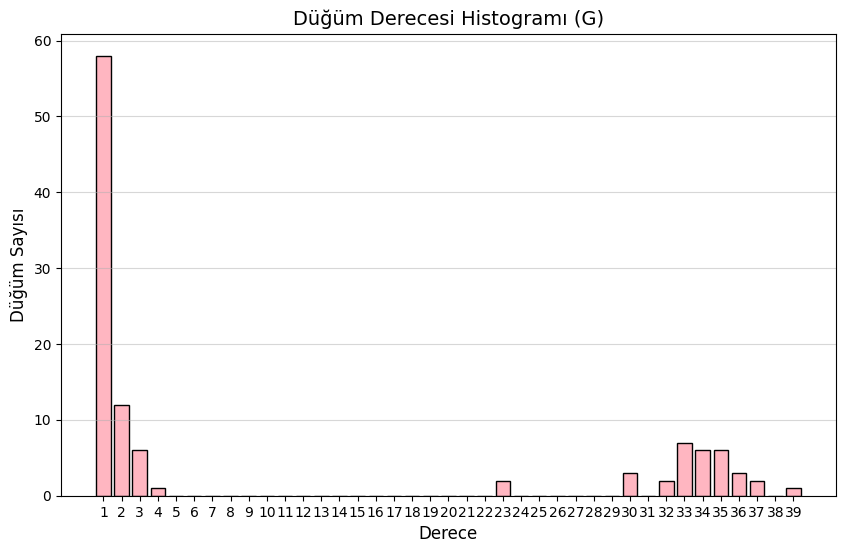

In [8]:
degree_values = list(degrees.values())
plt.figure(figsize=(10, 6))
plt.hist(degree_values, bins=range(min(degree_values), max(degree_values) + 2), align='left', rwidth=0.8, color='lightpink', edgecolor='black')
plt.title('Düğüm Derecesi Histogramı (G)', fontsize=14)
plt.xlabel('Derece', fontsize=12)
plt.ylabel('Düğüm Sayısı', fontsize=12)
plt.xticks(range(min(degree_values), max(degree_values) + 1))
plt.grid(axis='y', alpha=0.5)
plt.show()


In [13]:
deg_centrality = nx.degree_centrality(G)
cls_centrality = nx.closeness_centrality(G)
bet_centrality = nx.betweenness_centrality(G)

# 4. Eigenvector Centrality
try:
    eig_centrality = nx.eigenvector_centrality(G, max_iter=1000)
except nx.PowerIterationFailedConvergence:
    eig_centrality = nx.eigenvector_centrality(G, max_iter=5000)

katz_centrality = nx.katz_centrality(G, alpha=0.01, max_iter=1000, tol=1e-06)

# 6. PageRank
pr_centrality = nx.pagerank(G, alpha=0.85)

centrality_df = pd.DataFrame({
    'Degree Centrality': pd.Series(deg_centrality),
    'Closeness Centrality': pd.Series(cls_centrality),
    'Betweenness Centrality': pd.Series(bet_centrality),
    'Eigenvector Centrality': pd.Series(eig_centrality),
    'Katz Centrality': pd.Series(katz_centrality),
    'PageRank Centrality': pd.Series(pr_centrality)
}).fillna(0)

display(centrality_df.head())

,Degree Centrality,Closeness Centrality,Betweenness Centrality,Eigenvector Centrality,Katz Centrality,PageRank Centrality
Los Angeles Angels,0.277778,0.580645,0.000158,0.175113,0.117940,0.021114
Chicago White Sox,0.314815,0.593407,0.060652,0.176235,0.121244,0.027237
Los Angeles Dodgers,0.314815,0.593407,0.032810,0.180608,0.121523,0.025524
Chicago Cubs,0.305556,0.590164,0.018128,0.180220,0.120690,0.023957
Seattle Mariners,0.305556,0.590164,0.023551,0.176422,0.120448,0.024292


In [14]:
from networkx.algorithms.community import greedy_modularity_communities, modularity
communities = list(greedy_modularity_communities(G))
modularity_score = modularity(G, communities)
print(f"Modularity: {modularity_score:.4f}")

density = nx.density(G)
print(f"Density : {density:.4f}")

avg_clustering = nx.average_clustering(G)
print(f"Average Clustering: {avg_clustering:.4f}")

if nx.is_connected(G):
    diameter = nx.diameter(G)
else:
    G_largest = G.subgraph(max(nx.connected_components(G), key=len))
    diameter = nx.diameter(G_largest)
print(f"Diameter: {diameter}")

Modularity: 0.1276
Density : 0.0994
Average Clustering: 0.4115
Diameter: 3


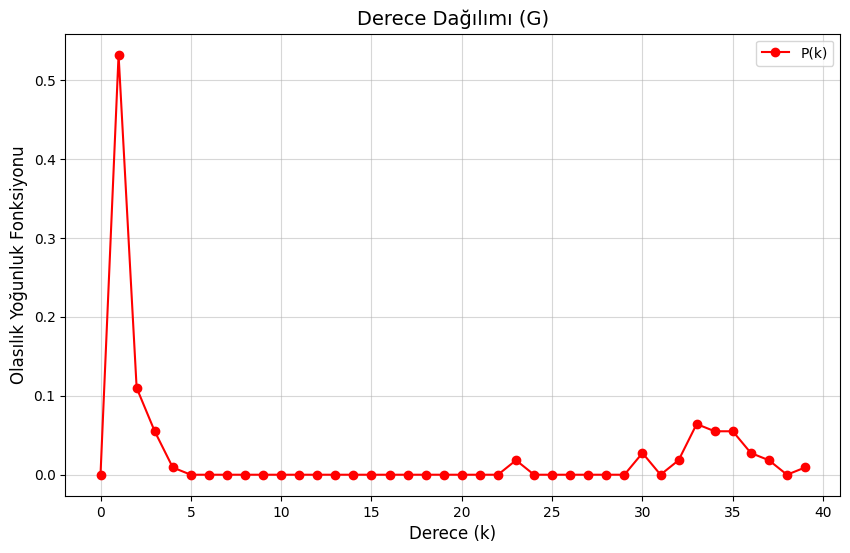

In [15]:
degree_counts = nx.degree_histogram(G)
degree_values_plot = range(len(degree_counts))
pk = [count / G.number_of_nodes() for count in degree_counts]

plt.figure(figsize=(10, 6))
plt.plot(degree_values_plot, pk, 'ro-', label='P(k)')
plt.title('Derece Dağılımı (G)', fontsize=14)
plt.xlabel('Derece (k)', fontsize=12)
plt.ylabel('Olasılık Yoğunluk Fonksiyonu', fontsize=12)
plt.legend()
plt.grid(axis='both', alpha=0.5)
plt.show()